## Lab 3 - PCR and PLS Regression

NOTES - Standardize is NOT Normalize

#### Import block

In [1]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import scale

# %matplotlib inline
# plt.style.use('seaborn-white')

Load data

In [2]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
hitter = pd.read_csv(f'{data_path}Hitters.csv', index_col=0, na_values='NA').dropna()

# Transform categorical variables into dummy
for i in ['League', 'Division', 'NewLeague']:
    hitter[i] = hitter[i].astype('category').cat.codes

hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0,1,282,421,25,750.0,0


### 6.7.1 - Principle Components Regression

Using pca from sklearn module

In [4]:
# Split data
y = hitter.Salary
X = hitter.drop('Salary', axis=1)

# Finding Principal Components
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
print(pd.Series(np.cumsum(np.round(pca.explained_variance_ratio_*100,decimals=2))
                , index=range(1,20)))

1     38.31
2     60.15
3     70.84
4     79.03
5     84.29
6     88.63
7     92.26
8     94.96
9     96.28
10    97.25
11    97.97
12    98.64
13    99.14
14    99.46
15    99.73
16    99.88
17    99.95
18    99.98
19    99.99
dtype: float64


Without passing any argument about which components to keep, we can see that the first 8 
principal components explain for 98% of the variance. 

Next, we will plot the MSE results from fitting OLS with 10-fold CV. 

Text(0.5, 1.0, 'PCA on full dataset with 10 fold')

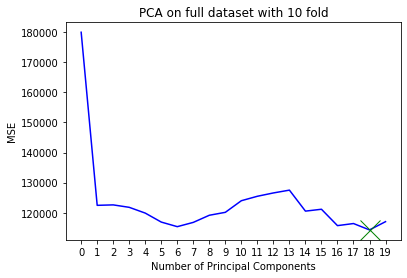

In [5]:
# Setting up all parameters # 19 principal components
k_fold = KFold(n_splits=10, shuffle=True, random_state=1)
mse = [180000]  # For a better graph
regr = skl_lm.LinearRegression()

# Loop through all components number and K-fold
for i in range(1, 20):
    mse.append(cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=k_fold, 
                                   scoring='neg_mean_squared_error').mean()*-1)


# Getting minimum MSE
min_mse_index, min_mse = min(enumerate(mse), key=itemgetter(1))

# Plot MSE
plt.plot(mse, color='b')
plt.plot(min_mse_index, min_mse, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('PCA on full dataset with 10 fold')

The plot gives us some useful information.
1. The minimum MSE occurs at 18 principle components which is not much better than 19 - 
performing OLS
2. However, at 5 principle components, we come very close to the minimum MSE so this
may be much more practical number of components to use.
3. Changing random_state variable in the code above will provide different results 
each time. But it always end with 5/6 near min MSE and 15/16/17 for min MSE.

Now, we perform the same analysis using train set and test set.

Text(0, 0.5, 'MSE')

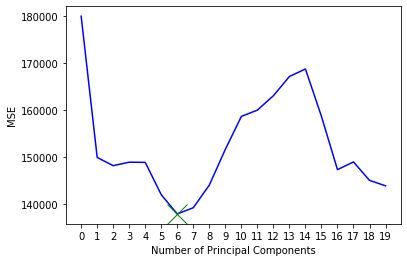

In [6]:
pca2 = PCA()
# splitting data
t_prop = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_prop, 
                                                    random_state=1)
X_reduced_train = pca2.fit_transform(scale(X_train))

# Setting up all parameters # 19 principal components
k_fold = KFold(n_splits=10, shuffle=True, random_state=1)
mse = [180000]
regr = skl_lm.LinearRegression()

# Loop through all components number and K-fold
for i in range(1, 20):
    mse.append(cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=k_fold, 
                                   scoring='neg_mean_squared_error').mean()*-1)


# Getting minimum MSE
min_mse_index, min_mse = min(enumerate(mse), key=itemgetter(1))

# Plot MSE
plt.plot(mse, color='b')
plt.plot(min_mse_index, min_mse, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')

Again, different random_state in both train_test_split and Kfold will produce wildly
different results. Nevertheless, setting them all to 1 to get a reproducible version

The plot shows that using 6 PC seems to be the best here. Next, we can calculate test
MSE using full data set and 6 PC

In [8]:
X_reduced_test = pca2.transform(scale(X_test))
# Get test error
pred = regr.fit(X_reduced_train[:,:7], y_train).predict(X_reduced_test[:,:7])
print(f'Test MSE with 6 PC: {mean_squared_error(y_test, pred)}')

Test MSE with 6 PC: 111994.42273636987


The MSE we got is not too bad. Again, keep in mind that how we split the data will 
strongly influence the result we get.  
As the final step, we would like to run PCR with 7 components on full dataset.
the 7 components explained 93.38% of the variance.

In [10]:
print(pd.Series(np.cumsum(np.round(pca.explained_variance_ratio_*100,decimals=2))
                , index=range(1,20))[:7])

1    38.31
2    60.15
3    70.84
4    79.03
5    84.29
6    88.63
7    92.26
dtype: float64


### 6.7.2 - Partial Least Square

PLS is a method of dimension reduction. Like PCR, PLS finds the best components that
can explains the most variance int the predictors. However, unlike PCR, PLS also 
searches for direction that explain variance in both predictors and the response.

We will first implement PLS using the training dataset.

Text(0, 0.5, 'MSE')

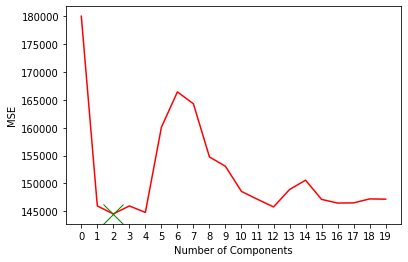

In [22]:
# Running PLS with 10 fold
k_fold = KFold(n_splits=10, random_state=4, shuffle=True)
mse = [180000]
for i in range(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=k_fold,
                               scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Find min mse
min_mse_index, min_mse = min(enumerate(mse), key=itemgetter(1))

# plot MSE  vs directions/components
plt.plot(mse, color='r', label='MSE')
plt.plot(min_mse_index, min_mse, color='g', marker='x', markersize=20)
plt.xticks(np.arange(0,20))
plt.xlabel('Number of Components')
plt.ylabel('MSE')    
    

Again, we have to play around with random state in K fold to get the desired results 
as in the book. However, most of the time, we will get either 1/2/3 directions or 11/12/13
directions with barely lower MSE than 1/2/3.

Finally, fitting PLS on full dataset to get the final MSE of our model with M=2

In [30]:
k_fold = KFold(n_splits=10, random_state=4, shuffle=True)
pls = PLSRegression(n_components=2)
score = cross_val_score(pls, scale(X), y, cv=k_fold, scoring='r2')
print(score)

[ 0.46563696  0.04852469 -0.17132481  0.46135197  0.76587847 -0.02321038
  0.12097518  0.47686936  0.56685367  0.65286968]


The first return number is our variance explained by 2 directions which is 46.56%.